Script to combine JSON simulation result files into a unified results structure.

Each input file must follow the naming convention:
    `{name}_sim{sim_id}_{timestamp}.json`

and contain a JSON object with keys:
- scenario_name: str
- sim_id: int
- agent_names: list of str
- cum_regrets: list of lists (one per agent)
- time_agents: list of lists (one per agent)

The script aggregates data across multiple files for the same scenario and sim_id,
producing a `results` dict:

```
results[scenario_name] = {
    "scenario_name": scenario_name,
    "sim_id": [list of sim_ids],
    "regrets": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
    "times": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
}
```

## Pre

In [1]:
import os
import glob
import json
import numpy as np

def load_and_combine(json_dir: str = '.'):
    # Temporary storage: scenario -> sim_id -> list of file data dicts
    files_data = {}

    # Collect and parse all JSON files
    for filepath in glob.glob(os.path.join(json_dir, '*.json')):
        with open(filepath, 'r') as f:
            data = json.load(f)
        scenario = data['scenario_name']
        sim_id = data['sim_id']
        files_data.setdefault(scenario, {}).setdefault(sim_id, []).append({
            'agent_names': data['agent_names'],
            'cum_regrets': data['cum_regrets'],
            'time_agents': data['time_agents'],
        })

    results = {}
    # Combine per scenario
    for scenario_name, sim_dict in files_data.items():
        # Determine all unique agent names
        all_agents = sorted({name for entries in sim_dict.values() for e in entries for name in e['agent_names']})

        # Simulation IDs sorted
        sim_ids = sorted(sim_dict.keys())
        n_simulations = max(sim_ids) + 1
        # Determine number of draws from the first entry
        sample = sim_dict[sim_ids[0]][0]
        n_draws = len(sample['cum_regrets'])

        # Allocate arrays for each agent
        all_regrets = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}
        all_times   = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}

        # Fill arrays with transposed data (draws × agents -> agents × draws)
        for sim_id, entries in sim_dict.items():
            for entry in entries:
                cum_regs = np.array(entry['cum_regrets'])   # shape: (n_draws, n_agents)
                time_ag  = np.array(entry['time_agents'])   # shape: (n_draws, n_agents)
                for i, name in enumerate(entry['agent_names']):
                    all_regrets[name][sim_id, :] = cum_regs[:, i]
                    all_times[name][sim_id, :]   = time_ag[:, i]

        # Build scenario's combined results
        results[scenario_name] = {
            'scenario_name': scenario_name,
            'sim_id': sim_ids,
            'regrets': all_regrets,
            'times': all_times,
        }

    return results

In [2]:
combined = load_and_combine('./results/compare_cli')

In [3]:
from compare_agents import *

# print_summary_results(combined)

In [4]:
combined = {k: combined[k] for k in [
    "Linear",
    "Friedman",
    "LinFriedman",
    "Friedman2",
    "Friedman3",
    "Magic",
    "Shuttle",
    "Adult",
    "Mushroom"
    ] if k in combined}

## Printed Info

In [5]:
print_topn_agents_per_scenario(combined, 15)


Top 15 agents per scenario:
                 Linear        Friedman     LinFriedman       Friedman2       Friedman3                   Magic                 Shuttle                   Adult                Mushroom
Rank 1        NLinearTS    NeuralTSDiag    NeuralTSDiag  BARTo_tree0.5x    NeuralTSDiag          BARTs_iter0.5x               NKernelTS  LogisticBARTm_tree0.5x            BARTs_tree2x
Rank 2         LinearTS    BARTs_iter2x         MCBARTs           BARTo  BARTo_tree0.5x                 MCBARTs          BARTo_tree0.5x    LogisticBARTm_tree2x          BARTs_tree0.5x
Rank 3       LinearTSme           BARTs    BARTs_iter2x  BARTo_iter0.5x    BARTo_iter2x            BARTs_iter2x          BARTo_iter0.5x         LogisticMCBARTm                   BARTm
Rank 4        NKernelTS    BARTs_tree2x           BARTs    BARTo_iter2x           BARTs          BARTs_tree0.5x                   BARTo                 MCBARTs                   BARTs
Rank 5   BARTm_tree0.5x  BARTs_tree0.5x  BARTs_iter

In [6]:
print_pairwise_win_tie_lose(combined)


Totals across all scenarios (sorted by win*3+tie):
                win  tie  lose
BARTo_iter2x     52  154    14
BARTo_tree0.5x   56  142    22
BARTo_iter0.5x   52  148    20
BARTo            52  142    26
NeuralTSDiag     45  160    15
MCBARTs          46  154    20
BARTm_iter2x     42  163    15
BARTs_iter2x     45  154    21
BARTs            44  156    20
BARTs_tree2x     44  155    21
BARTm            41  163    16
BARTs_tree0.5x   43  157    20
BARTs_iter0.5x   43  157    20
BARTo_tree2x     41  163    16
BARTm_tree0.5x   39  168    13
BARTm_tree2x     39  166    15
BARTm_iter0.5x   39  165    16
MCBARTm          39  165    16
NKernelTS        32  147    41
LinearTS         27   79   114
NLinearTS        33   57   130
LinearTSme       23   79   118
Random            0   32   188


In [7]:
print_relative_performance(combined)


Agent performance (relative to Random):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
BARTo_tree0.5x               0.234    0.054    0.163
BARTo_iter2x                 0.241    0.052    0.157
BARTo_iter0.5x               0.245    0.054    0.162
BARTo                        0.249    0.056    0.167
NeuralTSDiag                 0.254    0.067    0.202
LogisticBARTm_tree0.5x       0.260    0.097    0.194
LogisticBARTm                0.262    0.092    0.184
LogisticBARTm_iter0.5x       0.263    0.092    0.183
LogisticMCBARTm              0.267    0.094    0.188
LogisticBARTm_iter2x         0.268    0.094    0.187
LogisticBARTm_tree2x         0.268    0.092    0.183
BARTo_tree2x                 0.268    0.054    0.161
BARTm_iter2x                 0.301    0.090    0.269
BARTm                        0.306    0.092    0.277
BARTm_tree0.5x               0.307    0.098    0.295
BARTm_iter0.5x               0.308    0.091 

In [8]:
print_relative_performance(combined, "times")


Agent performance (relative to Random):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
Random                       0.085    0.005    0.016
LinearTS                     0.707    0.068    0.204
LinearTSme                   1.657    0.202    0.606
NLinearTS                    5.889    0.663    1.990
NKernelTS                   13.195    0.051    0.152
BARTs_tree0.5x              24.244    3.705   11.114
BARTs_iter0.5x              25.624    3.273    9.818
BARTo_iter0.5x              38.294    4.355   13.065
BARTm_iter0.5x              39.767    4.679   14.037
BARTs                       43.989    5.782   17.345
BARTm_tree0.5x              46.937   14.719   44.157
BARTo_tree0.5x              48.326   13.548   40.643
LogisticBARTm_tree0.5x      65.370    2.362    4.724
LogisticBARTm_iter0.5x      71.812    2.639    5.279
BARTo                       72.087   11.080   33.239
BARTm                       74.667   10.304 

## Plot & Print

In [9]:
plot_print_total_regret_factors(combined)


Mean relative regret by "Model" category (rows) and scenario (columns):
                   m        o        s  Logistic m
Adult        604.222  678.733  595.611     589.556
Average        0.308    0.247    0.375       0.265
Friedman    1202.424 1515.346  829.117         NaN
Friedman2    475.818  206.284  356.063         NaN
Friedman3    794.442  536.711  580.900         NaN
LinFriedman 1561.953 1364.618  841.089         NaN
Linear       519.061  585.837 1046.064         NaN
Magic        701.556  718.267  665.611     685.389
Mushroom      85.444  145.533   65.389     124.167
Shuttle      368.778  236.400 2568.667     331.500

Mean relative regret by "Tree" category (rows) and scenario (columns):
                0.5x       1x       2x
Adult        617.833  627.083  619.750
Average        0.298    0.304    0.316
Friedman    1169.352 1165.574 1181.532
Friedman2    347.350  342.985  355.065
Friedman3    604.057  618.759  661.430
LinFriedman 1228.991 1206.130 1254.485
Linear       687.150 

## "Beautiful" Plots

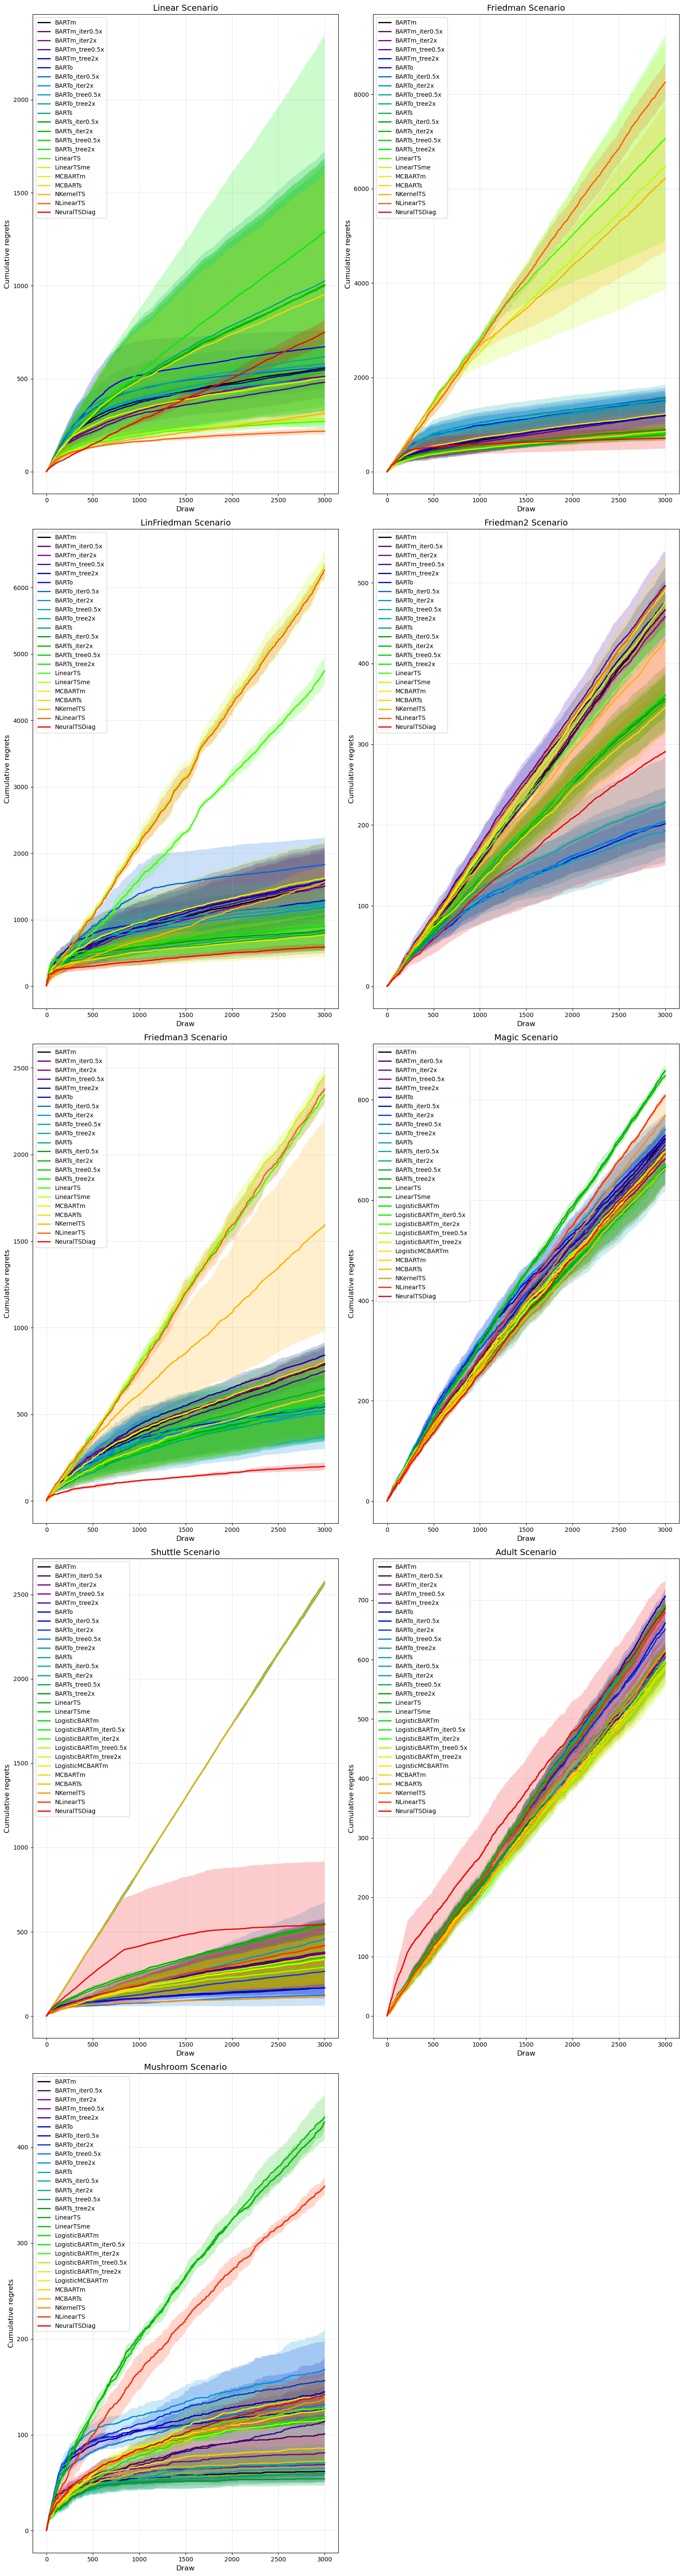

In [10]:
plot_comparison_results(combined, show_random=False)

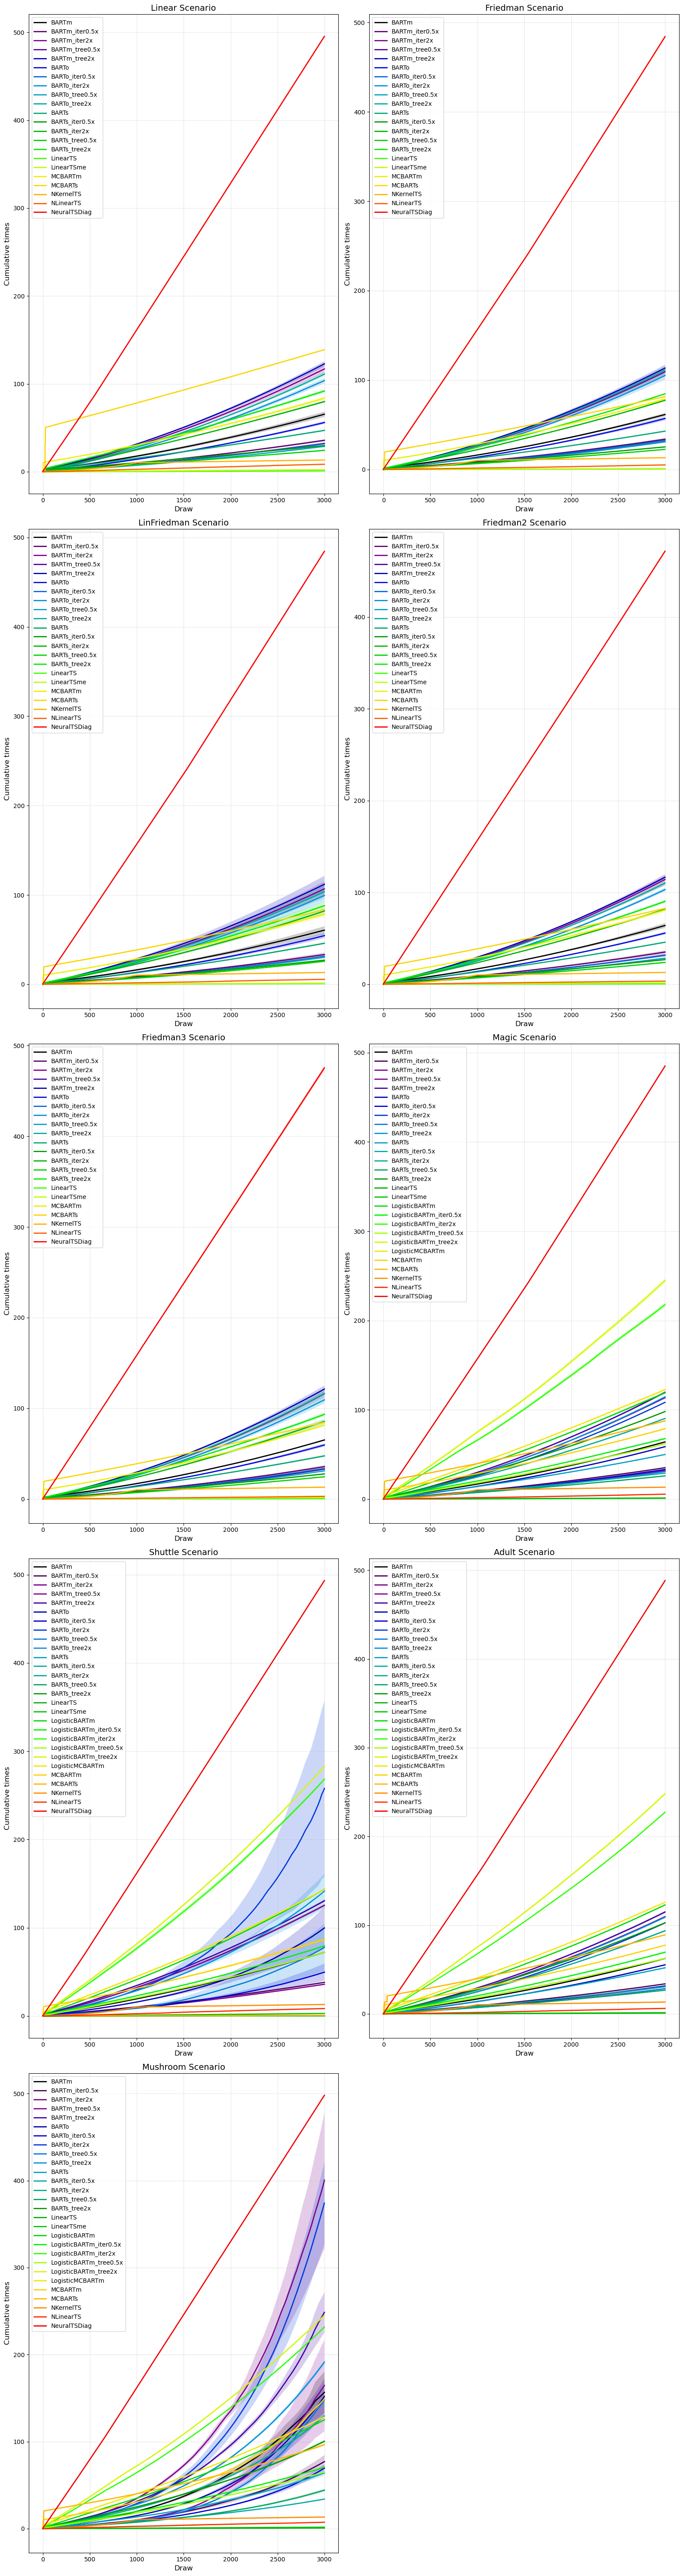

In [11]:
plot_comparison_results(combined, show_random=False, target="times")